In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline



In [92]:
class LaneDetection(object):
    
    def __init__(self, cal_images):
        self.cal_images = cal_images
        self.calibrate_camera()
    
    def set_obj_and_img_points(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
    
        # Step through the list and search for chessboard corners
        for fname in self.cal_images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
#             if not ret: print(fname)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    def calibrate_camera(self):
        self.set_obj_and_img_points()
        if len(self.objpoints) == 0 or len(self.imgpoints) == 0:
            raise Exception("Calibration Failed!")
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, mtx)
    
    def to_gray(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def top_view(self, img):
        # Use the OpenCV undistort() function to remove distortion
        undist = self.undistort(img)
        
        # Convert undistorted image to grayscale
        gray = self.to_gray(undist)
        
    def binary_transform(self, img, orient='x', thresh_min=0, thresh_max=255, ksize=5):
        print(ksize)
        # Convert to grayscale
        gray = self.to_gray(img)
        
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
       
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output
#         return scaled_sobel


In [123]:
lane_detection = LaneDetection(glob.glob('camera_cal/calibration*.jpg'))

7


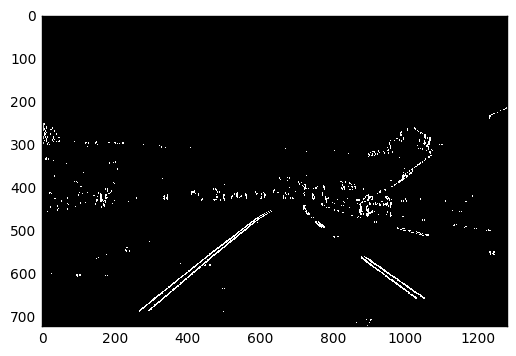

In [156]:
img = cv2.imread('test_images/test3.jpg')
dst = lane_detection.binary_transform(img, thresh_min=40, thresh_max=200, ksize=7)
cv2.imwrite('output_images/binary_test3.jpg', dst*255)
plt.imshow(dst, interpolation='nearest', aspect='auto', cmap='gray')